In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read data

In [2]:
metadata_str = 'mgp93_metadata.csv'
data_str = 'mgp93_data_genus.tsv'

In [3]:
df_metadata = pd.read_csv(metadata_str)
df_data = pd.read_csv(data_str, sep='\t')

df_metadata = df_metadata.drop([0], axis=0) # first row is a description of each column
#df_metadata = df_metadata.loc[df_metadata['mislabeled'] == 'n'] # drop mislabeled data

### Manipulate data
Need this in order to the match metadata with the data.

In [4]:
## Do some meta_data manipulation

# Only keep useful metadata columns
metadata_useful = ['sample_name', 'collection_date', 'common_sample_site', 'host_individual', 'mislabeled']
df_metadata = df_metadata.loc[:, metadata_useful]
# Index on sample_name so we can combine the meta_data with the data
df_metadata = df_metadata.set_index('sample_name')

## Do some data manipulation

# Change file names to match those in meta_data
df_data.columns = [col_title.split('.', 1)[0] for col_title in df_data.columns]
# Drop unclassified genus
df_data = df_data.drop(index = (df_data[df_data['genus'].str.contains("unclassified")]).index)

In [5]:
# Make the metadata and the data dataframes match and...
df_data_1 = pd.concat([(df_data.T).iloc[0:6], (df_data.T).iloc[6:].sort_index()])
df_metadata_1 = pd.concat([pd.DataFrame(np.nan, index=df_data_1.iloc[0:6].index.values, columns=df_metadata.columns), df_metadata])
# ...concatanate them
df_data = pd.concat([df_metadata_1, df_data_1], axis=1, sort=False)

In [6]:
df_data.insert(0, 'sample_name', df_data.index.values) # to store once the index will be reset
# Set index to days (in float) since first sampling
df_data['collection_date'] = pd.to_datetime(df_data['collection_date'])
df_data.loc['L1S1':] = (df_data.loc['L1S1':].sort_values(by='collection_date')).values
t0 = df_data['collection_date'][6]
df_data['days'] = (df_data['collection_date']-t0).astype('timedelta64[D]')# Time difference in days (converted to floats)
df_data = df_data.set_index('days')

### Clean data

In [7]:
# Eliminate mislabeled data
df_data = df_data[(df_data.mislabeled == 'n')  | (df_data['mislabeled'].isnull())]

# Select data for a certain subject and sample location
df_data_F_gut = df_data[((df_data.host_individual == 'F4') | (df_data['host_individual'].isnull()))
                       & ((df_data.common_sample_site == 'feces') | (df_data['common_sample_site'].isnull()))]

### Plot

In [106]:
data_range = np.arange(6, 20) # 6 is the first genus
y = df_data_F_gut.loc[1:, df_data_F_gut.columns[data_range]]
x = df_data_F_gut[1:].index.values
legend_list = df_data_F_gut.loc[df_data_F_gut['sample_name'] == 'genus'].loc[:, df_data_F_gut.columns[data_range]].values[0]

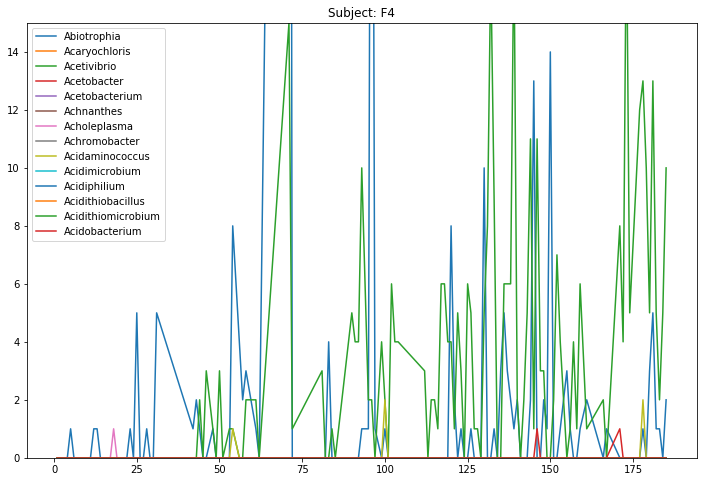

In [108]:
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.ylim([0,15])
plt.legend(legend_list)
plt.title('Subject: F4')
plt.show()